In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time
from math import floor

In [240]:
operation_count = 0

def generate_random_matrix(size):
    return np.random.uniform(1e-8, 1.0, (size, size))

def is_power_of_two(n):
    return n > 0 and (n & (n - 1)) == 0

def is_the_right_size(matrix):
    rows, columns = matrix.shape
    return rows == columns and is_power_of_two(rows)

def pad_to_power_of_two(matrix):
    rows, cols = matrix.shape
    new_size = 1 << max(rows, cols).bit_length()

    padded_matrix = np.zeros((new_size, new_size))
    padded_matrix[:rows, :cols] = matrix

    return padded_matrix

def restore_original(matrix, size):
    return matrix[:size, :size]

Algorytm Binét’a

In [18]:
def matrix_mult_recursive(A, B):
    global operation_count

    n = A.shape[0]

    if n == 1:
        operation_count += 1
        return A * B
    elif A[0, 0] == 0:
        return np.zeros_like(A)
    
    mid = n // 2

    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    B11 = B[:mid, :mid]
    B12 = B[:mid, mid:]
    B21 = B[mid:, :mid]
    B22 = B[mid:, mid:]

    C11 = matrix_mult_recursive(A11, B11) + matrix_mult_recursive(A12, B21)
    C12 = matrix_mult_recursive(A11, B12) + matrix_mult_recursive(A12, B22)
    C21 = matrix_mult_recursive(A21, B11) + matrix_mult_recursive(A22, B21)
    C22 = matrix_mult_recursive(A21, B12) + matrix_mult_recursive(A22, B22)

    operation_count += n * n

    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))

    return C

In [19]:
A = generate_random_matrix(33)
B = generate_random_matrix(33)

A = pad_to_power_of_two(A)
B = pad_to_power_of_two(B)

C1 = matrix_mult_recursive(A, B)
C2 = A @ B


if np.allclose(C1, C2):
    print("Success")

else:
    print("Incorrect result")


Success


Algorytm Strassena

In [20]:
def add_matrix(A, B):
    global operation_count
    operation_count += A.shape[0] * B.shape[0]
    return A + B

def sub_matrix(A, B):
    global operation_count
    operation_count += A.shape[0] * B.shape[0]
    return A - B

In [21]:
def strassen_recursive(A, B):
    global operation_count

    n = A.shape[0]

    if n == 1:
        operation_count += 1
        return A * B
    elif A[0 ,0] == 0:
        return np.zeros_like(A)
    
    mid = n // 2

    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    B11 = B[:mid, :mid]
    B12 = B[:mid, mid:]
    B21 = B[mid:, :mid]
    B22 = B[mid:, mid:]

    P1 = strassen_recursive(add_matrix(A11, A22), add_matrix(B11, B22))
    P2 = strassen_recursive(add_matrix(A21, A22), B11)
    P3 = strassen_recursive(A11, sub_matrix(B12, B22))
    P4 = strassen_recursive(A22, sub_matrix(B21, B11))
    P5 = strassen_recursive(add_matrix(A11, A12), B22)
    P6 = strassen_recursive(sub_matrix(A21, A11), add_matrix(B11, B12))
    P7 = strassen_recursive(sub_matrix(A12, A22), add_matrix(B21, B22))

    C11 = add_matrix(sub_matrix(add_matrix(P1, P4), P5), P7)
    C12 = add_matrix(P3, P5)
    C21 = add_matrix(P2, P4)
    C22 = add_matrix(sub_matrix(add_matrix(P1, P3), P2), P6)

    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))

    return C

In [22]:
A = generate_random_matrix(8)
B = generate_random_matrix(8)

C1 = strassen_recursive(A, B)
C2 = A @ B

if np.allclose(C1, C2):
    print("Success")

else:
    print("Incorrect result")

Success


Metoda AI z artykułu w Nature

In [267]:
def next_power_of_four(n):
    val = 1
    while (val) < n:
        val *= 4
    return val
    
def next_power_of_five(n):
    val = 1
    while (val) < n:
        val *= 5
    return val


def pad_to_4n_5n(matrix):
    rows, cols = matrix.shape

    n_rows = next_power_of_four(rows)
    n_cols = next_power_of_five(cols)

    padded_matrix = np.zeros((n_rows, n_cols))

    padded_matrix[:rows, :cols] = matrix

    return padded_matrix

def pad_to_5n(matrix):
    rows, cols = matrix.shape

    new_size = next_power_of_five(max(rows, cols))

    padded_matrix = np.zeros((new_size, new_size))

    padded_matrix[:rows, :cols] = matrix

    return padded_matrix

def restore_original_4n_5n(matrix, x, y):
    return matrix[:x, :y]

In [24]:
def ai_recursive(A, B):
    An_rows, An_cols = A.shape

    if An_rows == 1:
        return A * B

    p = An_rows // 4
    q = An_cols // 5

    An = np.empty((4, 5), dtype=object)
    for i in range(4):
        for j in range(5):
            An[i, j] = A[i*p:(i+1)*p, j*q:(j+1)*q]

    Bn = np.empty((5, 5), dtype=object)

    for i in range(5):
        for j in range(5):
            Bn[i, j] = B[i*q:(i+1)*q, j*q:(j+1)*q]

    C = np.empty((4, 5), dtype=object)

    h1 = ai_recursive(An[2, 1], (-Bn[1, 0] - Bn[1, 4] - Bn[2, 0]))
    h2 = ai_recursive((An[1, 1] + An[1, 4] - An[2, 4]), (-Bn[1, 4] - Bn[4, 0]))
    h3 = ai_recursive((-An[2, 0] - An[3, 0] + An[3, 1]), (-Bn[0, 0] + Bn[1, 4]))
    h4 = ai_recursive((An[0, 1] + An[0, 3] + An[2, 3]), (-Bn[1, 4] - Bn[3, 0]))
    h5 = ai_recursive((An[0, 4] + An[1, 1] + An[1, 4]), (-Bn[1, 3] + Bn[4, 0]))
    h6 = ai_recursive((-An[1, 1] - An[1, 4] - An[3, 4]), (Bn[1, 2] + Bn[4, 0]))
    h7 = ai_recursive((-An[0, 0] + An[3, 0] - An[3, 1]), (Bn[0, 0] + Bn[1, 3]))
    h8 = ai_recursive((An[2, 1] - An[2, 2] - An[3, 2]), (-Bn[1, 2] + Bn[2, 0]))
    h9 = ai_recursive((-An[0, 1] - An[0, 3] + An[3, 3]), (Bn[1, 2] + Bn[3, 0]))
    h10 = ai_recursive((An[1, 1] + An[1, 4]), Bn[4, 0])
    h11 = ai_recursive((-An[1, 0] - An[3, 0] + An[3, 1]), (-Bn[0, 0] + Bn[1, 1]))
    h12 = ai_recursive((An[3, 0] - An[3, 1]), Bn[0, 0])
    h13 = ai_recursive((An[0, 1] + An[0, 3] + An[1, 3]), (Bn[1, 1] + Bn[3, 0]))
    h14 = ai_recursive((An[0, 2] - An[2, 1] + An[2, 2]), (Bn[1, 3] + Bn[2, 0]))
    h15 = ai_recursive((-An[0, 1] - An[0, 3]), Bn[3, 0])
    h16 = ai_recursive((-An[2, 1] + An[2, 2]), Bn[2, 0])
    h17 = ai_recursive((An[0, 1] + An[0, 3] - An[1, 0] + An[1, 1] - An[1, 2] + An[1, 3] - An[2, 1] + An[2, 2] - An[3, 0] + An[3, 1]), Bn[1, 1])
    h18 = ai_recursive(An[1, 0], (Bn[0, 0] + Bn[0, 1] + Bn[4, 1]))
    h19 = ai_recursive(-An[1, 2], (Bn[2, 0] + Bn[2, 1] + Bn[4, 1]))
    h20 = ai_recursive((-An[0, 4] + An[1, 0] + An[1, 2] - An[1, 4]), (-Bn[0, 0] - Bn[0, 1] + Bn[0, 3] - Bn[4, 1]))
    h21 = ai_recursive((An[1, 0] + An[1, 2] - An[1, 4]), Bn[4, 1])
    h22 = ai_recursive((An[0, 2] - An[0, 3] - An[1, 3]), (Bn[0, 0] + Bn[0, 1] - Bn[0, 3] - Bn[2, 0] - Bn[2, 1] + Bn[2, 3] + Bn[3, 3]))
    h23 = ai_recursive(An[0, 2], (-Bn[2, 0] + Bn[2, 3] + Bn[3, 3]))
    h24 = ai_recursive(An[0, 4], (-Bn[3, 3] - Bn[4, 0] + Bn[4, 3]))
    h25 = ai_recursive(-An[0, 0], (Bn[0, 0] - Bn[0, 3]))
    h26 = ai_recursive((-An[0, 2] + An[0, 3] + An[0, 4]), Bn[3, 3])
    h27 = ai_recursive((An[0, 2] - An[2, 0] + An[2, 2]), (Bn[0, 0] - Bn[0, 3] + Bn[0, 4] + Bn[2, 4]))
    h28 = ai_recursive(-An[2, 3], (-Bn[2, 4] - Bn[3, 0] - Bn[3, 4]))
    h29 = ai_recursive(An[2, 0], (Bn[0, 0] + Bn[0, 4] + Bn[2, 4]))
    h30 = ai_recursive((An[2, 0] - An[2, 2] + An[2, 3]), Bn[2, 4])
    h31 = ai_recursive((-An[0, 3] - An[0, 4] - An[2, 3]), (-Bn[3, 3] - Bn[4, 0] + Bn[4, 3] - Bn[4, 4]))
    h32 = ai_recursive((An[1, 0] + An[3, 0] + An[3, 3]), (Bn[0, 2] - Bn[3, 0] - Bn[3, 1] - Bn[3, 2]))
    h33 = ai_recursive(An[3, 2], (-Bn[2, 0] - Bn[2, 2]))
    h34 = ai_recursive(An[3, 3], (-Bn[0, 2] + Bn[3, 0] + Bn[3, 2]))
    h35 = ai_recursive(-An[3, 4], (Bn[0, 2] + Bn[4, 0] + Bn[4, 2]))
    h36 = ai_recursive((An[1, 2] - An[1, 4] - An[3, 4]), (Bn[2, 0] + Bn[2, 1] + Bn[2, 2] + Bn[4, 1]))
    h37 = ai_recursive((-An[3, 0] - An[3, 3] + An[3, 4]), Bn[0, 2])
    h38 = ai_recursive((-An[1, 2] - An[2, 0] + An[2, 2] - An[2, 3]), (Bn[2, 4] + Bn[3, 0] + Bn[3, 1] + Bn[3, 4]))
    h39 = ai_recursive((-An[2, 0] - An[3, 0] - An[3, 3] + An[3, 4]), (Bn[0, 2] + Bn[4, 0] + Bn[4, 2] + Bn[4, 4]))
    h40 = ai_recursive((-An[0, 2] + An[0, 3] + An[0, 4] - An[3, 3]), (-Bn[2, 0] - Bn[2, 2] + Bn[2, 3] + Bn[3, 3]))
    h41 = ai_recursive((-An[0, 0] + An[3, 0] - An[3, 4]), (Bn[0, 2] + Bn[2, 0] + Bn[2, 2] - Bn[2, 3] + Bn[4, 0] + Bn[4, 2] - Bn[4, 3]))
    h42 = ai_recursive((-An[1, 0] + An[1, 4] - An[2, 4]), (-Bn[0, 0] - Bn[0, 1] - Bn[0, 4] + Bn[3, 0] + Bn[3, 1] + Bn[3, 4] - Bn[4, 1]))
    h43 = ai_recursive(An[1, 3], (Bn[3, 0] + Bn[3, 1]))
    h44 = ai_recursive((An[1, 2] + An[2, 1] - An[2, 2]), (Bn[1, 1] - Bn[2, 0]))
    h45 = ai_recursive((-An[2, 2] + An[2, 3] - An[3, 2]), (Bn[2, 4] + Bn[3, 0] + Bn[3, 2] + Bn[3, 4] + Bn[4, 0] + Bn[4, 2] + Bn[4, 4]))
    h46 = ai_recursive(-An[2, 4], (-Bn[4, 0] - Bn[4, 4]))
    h47 = ai_recursive((An[1, 0] - An[1, 4] - An[2, 0] + An[2, 4]), (Bn[0, 0] + Bn[0, 1] + Bn[0, 4] - Bn[3, 0] - Bn[3, 1] - Bn[3, 4]))
    h48 = ai_recursive((-An[1, 2] + An[2, 2]), (Bn[1, 1] + Bn[2, 1] + Bn[2, 4] + Bn[3, 0] + Bn[3, 1] + Bn[3, 4]))
    h49 = ai_recursive((-An[0, 0] - An[0, 2] + An[0, 3] + An[0, 4] - An[1, 0] - An[1, 2] + An[1, 3] + An[1, 4]), (-Bn[0, 0] - Bn[0, 1] + Bn[0, 3]))
    h50 = ai_recursive((-An[0, 3] - An[1, 3]), (Bn[1, 1] - Bn[2, 0] - Bn[2, 1] + Bn[2, 3] - Bn[3, 1] + Bn[3, 3]))
    h51 = ai_recursive(An[1, 1], (Bn[1, 0] + Bn[1, 1] - Bn[4, 0]))
    h52 = ai_recursive(An[3, 1], (Bn[0, 0] + Bn[1, 0] + Bn[1, 2]))
    h53 = ai_recursive(-An[0, 1], (-Bn[1, 0] + Bn[1, 3] + Bn[3, 0]))
    h54 = ai_recursive((An[0, 1] + An[0, 3] - An[1, 1] - An[1, 4] - An[2, 1] + An[2, 2] - An[3, 1] + An[3, 2] - An[3, 3] - An[3, 4]), Bn[1, 2])
    h55 = ai_recursive((An[0, 3] - An[3, 3]), (-Bn[1, 2] + Bn[2, 0] + Bn[2, 2] - Bn[2, 3] + Bn[3, 2] - Bn[3, 3]))
    h56 = ai_recursive((An[0, 0] - An[0, 4] - An[3, 0] + An[3, 4]), (Bn[2, 0] + Bn[2, 2] - Bn[2, 3] + Bn[4, 0] + Bn[4, 2] - Bn[4, 3]))
    h57 = ai_recursive((-An[2, 0] - An[3, 0]), (-Bn[0, 2] - Bn[0, 4] - Bn[1, 4] - Bn[4, 0] - Bn[4, 2] - Bn[4, 4]))
    h58 = ai_recursive((-An[0, 3] - An[0, 4] - An[2, 3] - An[2, 4]), (-Bn[4, 0] + Bn[4, 3] - Bn[4, 4]))
    h59 = ai_recursive((-An[2, 2] + An[2, 3] - An[3, 2] + An[3, 3]), (Bn[3, 0] + Bn[3, 2] + Bn[3, 4] + Bn[4, 0] + Bn[4, 2] + Bn[4, 4]))
    h60 = ai_recursive((An[1, 4] + An[3, 4]), (Bn[1, 2] - Bn[2, 0] - Bn[2, 1] - Bn[2, 2] - Bn[4, 1] - Bn[4, 2]))
    h61 = ai_recursive((An[0, 3] + An[2, 3]), (Bn[0, 0] - Bn[0, 3] + Bn[0, 4] - Bn[1, 4] - Bn[3, 3] + Bn[3, 4] - Bn[4, 0] + Bn[4, 3] - Bn[4, 4]))
    h62 = ai_recursive((An[1, 0] + An[3, 0]), (Bn[0, 1] + Bn[0, 2] + Bn[1, 1] - Bn[3, 0] - Bn[3, 1] - Bn[3, 2]))
    h63 = ai_recursive((-An[2, 2] - An[3, 2]), (-Bn[1, 2] - Bn[2, 2] - Bn[2, 4] - Bn[3, 0] - Bn[3, 2] - Bn[3, 4]))
    h64 = ai_recursive((An[0, 0] - An[0, 2] - An[0, 3] + An[2, 0] - An[2, 2] - An[2, 3]), (Bn[0, 0] - Bn[0, 3] + Bn[0, 4]))
    h65 = ai_recursive((-An[0, 0] + An[3, 0]), (-Bn[0, 2] + Bn[0, 3] + Bn[1, 3] - Bn[4, 0] - Bn[4, 2] + Bn[4, 3]))
    h66 = ai_recursive((An[0, 0] - An[0, 1] + An[0, 2] - An[0, 4] - An[1, 1] - An[1, 4] - An[2, 1] + An[2, 2] - An[3, 0] + An[3, 1]), Bn[1, 3])
    h67 = ai_recursive((An[1, 4] - An[2, 4]), (Bn[0, 0] + Bn[0, 1] + Bn[0, 4] - Bn[1, 4] - Bn[3, 0] - Bn[3, 1] - Bn[3, 4] + Bn[4, 1] + Bn[4, 4]))
    h68 = ai_recursive((An[0, 0] + An[0, 2] - An[0, 3] - An[0, 4] - An[3, 0] - An[3, 2] + An[3, 3] + An[3, 4]), (-Bn[2, 0] - Bn[2, 2] + Bn[2, 3]))
    h69 = ai_recursive((-An[0, 2] + An[0, 3] - An[1, 2] + An[1, 3]), (-Bn[1, 3] - Bn[2, 0] - Bn[2, 1] + Bn[2, 3] - Bn[4, 1] + Bn[4, 3]))
    h70 = ai_recursive((An[1, 2] - An[1, 4] + An[3, 2] - An[3, 4]), (-Bn[2, 0] - Bn[2, 1] - Bn[2, 2]))
    h71 = ai_recursive((-An[2, 0] + An[2, 2] - An[2, 3] + An[2, 4] - An[3, 0] + An[3, 2] - An[3, 3] + An[3, 4]), (-Bn[4, 0] - Bn[4, 2] - Bn[4, 4]))
    h72 = ai_recursive((-An[1, 0] - An[1, 3] - An[3, 0] - An[3, 3]), (Bn[3, 0] + Bn[3, 1] + Bn[3, 2]))
    h73 = ai_recursive((An[0, 2] - An[0, 3] - An[0, 4] + An[1, 2] - An[1, 3] - An[1, 4]), (Bn[0, 0] + Bn[0, 1] - Bn[0, 3] + Bn[1, 3] + Bn[4, 1] - Bn[4, 3]))
    h74 = ai_recursive((An[1, 0] - An[1, 2] + An[1, 3] - An[2, 0] + An[2, 2] - An[2, 3]), (Bn[3, 0] + Bn[3, 1] + Bn[3, 4]))
    h75 = ai_recursive(-(An[0, 1] + An[0, 3] - An[1, 1] - An[1, 4] - An[2, 0] + An[2, 1] + An[2, 3] + An[2, 4] - An[3, 0] + An[3, 1]), Bn[1, 4])
    h76 = ai_recursive((An[0, 2] + An[2, 2]), (-Bn[0, 0] + Bn[0, 3] - Bn[0, 4] + Bn[1, 3] + Bn[2, 3] - Bn[2, 4]))


    C[0, 0] = -h10 + h12 + h14 - h15 - h16 + h53 + h5 - h66 - h7
    C[1, 0] = h10 + h11 - h12 + h13 + h15 + h16 - h17 - h44 + h51
    C[2, 0] = h10 - h12 + h15 + h16 - h1 + h2 + h3 - h4 + h75
    C[3, 0] = -h10 + h12 - h15 - h16 + h52 + h54 - h6 - h8 + h9
    C[0, 1] = h13 + h15 + h20 + h21 - h22 + h23 + h25 - h43 + h49 + h50
    C[1, 1] = -h11 + h12 - h13 - h15 - h16 + h17 + h18 - h19 - h21 + h43 + h44
    C[2, 1] = -h16 - h19 - h21 - h28 - h29 - h38 + h42 + h44 - h47 + h48
    C[3, 1] = h11 - h12 - h18 + h21 - h32 + h33 - h34 - h36 + h62 - h70
    C[0, 2] = h15 + h23 + h24 + h34 - h37 + h40 - h41 + h55 - h56 - h9
    C[1, 2] = -h10 + h19 + h32 + h35 + h36 + h37 - h43 - h60 - h6 - h72
    C[2, 2] = -h16 - h28 + h33 + h37 - h39 + h45 - h46 + h63 - h71 - h8
    C[3, 2] = h10 + h15 + h16 - h33 + h34 - h35 - h37 - h54 + h6 + h8 - h9
    C[0, 3] = -h10 + h12 + h14 - h16 + h23 + h24 + h25 + h26 + h5 - h66 - h7
    C[1, 3] = h10 + h18 - h19 + h20 - h22 - h24 - h26 - h5 - h69 + h73
    C[2, 3] = -h14 + h16 - h23 - h26 + h27 + h29 + h31 + h46 - h58 + h76
    C[3, 3] = h12 + h25 + h26 - h33 - h35 - h40 + h41 + h65 - h68 - h7
    C[0, 4] = h15 + h24 + h25+ h27 - h28 + h30 + h31 - h4 + h61 + h64
    C[1, 4] = -h10 - h18 - h2 - h30 - h38 + h42 - h43 + h46 + h67 + h74
    C[2, 4] = -h10 + h12 - h15 + h28 + h29 - h2 - h30 - h3 + h46 + h4 - h75
    C[3, 4] = -h12 - h29 + h30 - h34 + h35 + h39 + h3 - h45 + h57 + h59

    C = np.vstack((np.hstack((C[0, :])),
                  np.hstack((C[1, :])),
                  np.hstack((C[2, :])),
                  np.hstack((C[3, :]))))

    return C

In [25]:
A = generate_random_matrix(12)
B = generate_random_matrix(12)

A = pad_to_4n_5n(A)
B = pad_to_5n(B)

C1 = ai_recursive(A, B)
C2 = A @ B

if np.allclose(C1, C2):
    print("Success")

else:
    print("Incorrect result")

Success


Testy wydajnościowe


In [26]:
def draw_time_comparison(xs, binet, strassen, ai):

    plt.figure(figsize=(10, 6))
    plt.plot(xs, strassen, label='Algorytm Strassena', color='orange', marker='o')
    plt.plot(xs, binet, label='Algorytm Binéta', color='blue', marker='x')
    plt.plot(xs, ai, label='Algorytm AI', color='red', marker='*')
    plt.xlabel('Rozmiar macierzy (n x n)')
    plt.ylabel('Czas (sekundy)')
    plt.title('Porównanie wydajności')
    plt.legend()
    plt.grid(True)
    plt.savefig('Porównanie_czasu_działania.png')
    plt.show()

In [27]:
def draw_flops_comparison(xs, binet, strassen): 

    plt.figure(figsize=(10, 6))
    plt.plot(xs, strassen, label='Algorytm Strassena')
    plt.plot(xs, binet, label='Algorytm Binéta')
    plt.xlabel('Rozmiar macierzy (n x n)')
    plt.ylabel('Liczba operacji zmiennoprzecinkowych')
    plt.title('Porównanie liczby operacji')
    plt.legend()
    plt.grid(True)
    plt.savefig('Porównanie_liczby_operacji.png')
    plt.show()

In [28]:
def test_algorithms(sizes):
    global operation_count
    strassen_times = []
    binet_times = []
    ai_times = []

    strassen_operations = []
    binet_operations = []

    for size in sizes:
        A = generate_random_matrix(size)
        B = generate_random_matrix(size)
        
        if not is_the_right_size(A):
            A = pad_to_power_of_two(A)

        if not is_the_right_size(B):
            B = pad_to_power_of_two(B)

        # Strassen
        operation_count = 0
        start = time.time()
        C = strassen_recursive(A, B)
        strassen_times.append(time.time() - start)
        strassen_operations.append(operation_count)

        # Binét
        operation_count = 0
        start = time.time()
        C = matrix_mult_recursive(A, B)
        binet_times.append(time.time() - start)
        binet_operations.append(operation_count)

        A = pad_to_4n_5n(A)
        B = pad_to_5n(B)

        # AI
        start = time.time()
        C = ai_recursive(A, B)
        ai_times.append(time.time() - start)


    return binet_times, strassen_times, ai_times, binet_operations, strassen_operations


In [29]:
sizes = [2, 4, 8, 16, 32, 64]
binet_times, strassen_times, ai_times, binet_operations, strassen_operations = test_algorithms(sizes)

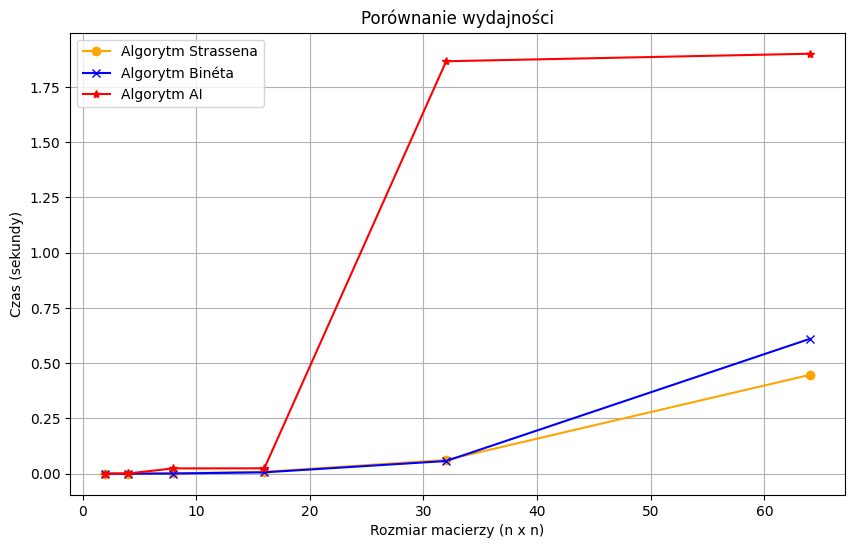

In [30]:
draw_time_comparison(sizes, binet_times, strassen_times, ai_times)

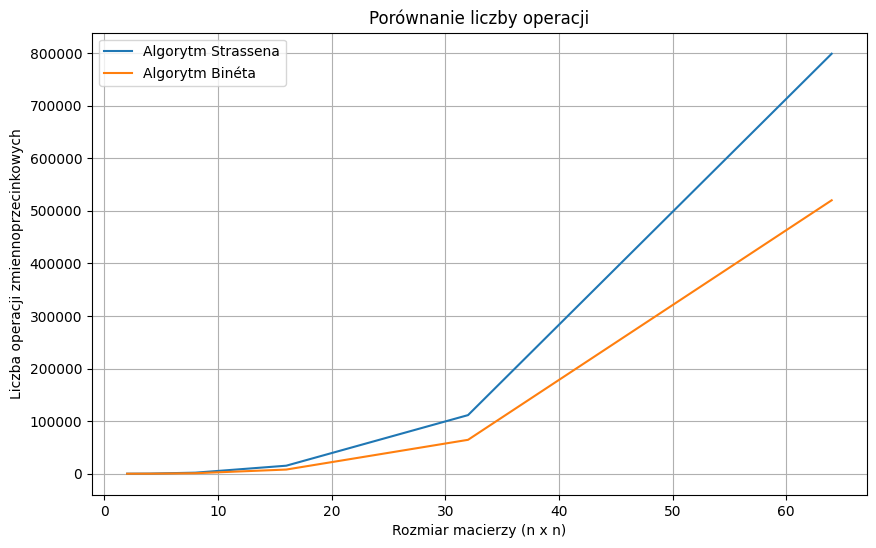

In [31]:
draw_flops_comparison(sizes, binet_operations, strassen_operations)

In [45]:
sizes = [i for i in range(2, 65)]
binet_times, strassen_times, ai_times, binet_operations, strassen_operations = test_algorithms(sizes)

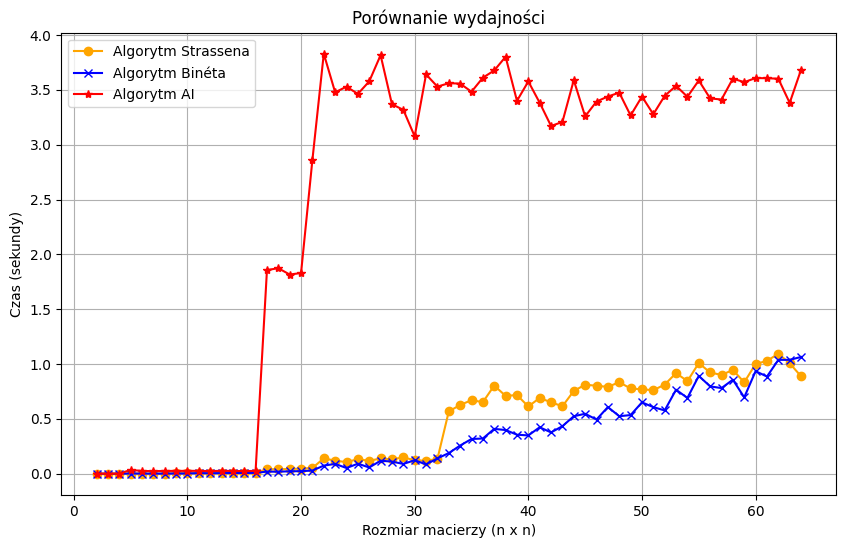

In [46]:
draw_time_comparison(sizes, binet_times, strassen_times, ai_times)

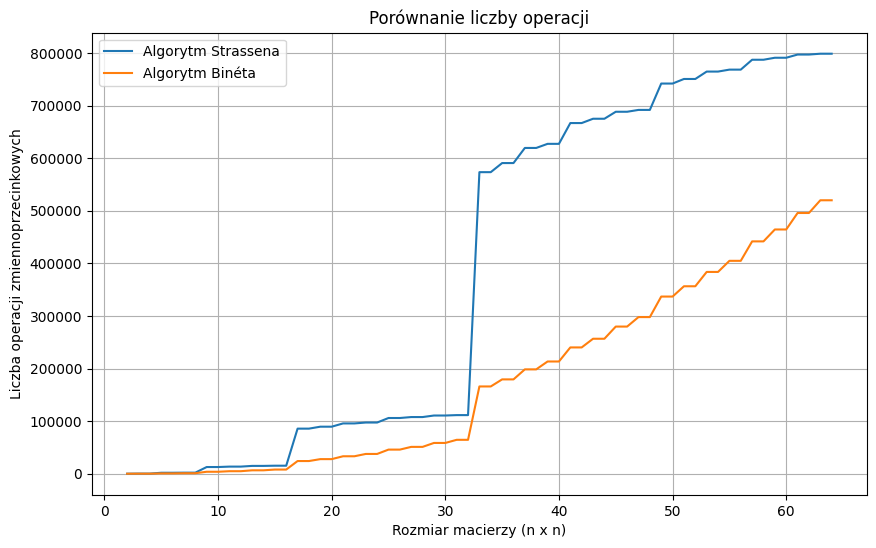

In [47]:
draw_flops_comparison(sizes, binet_operations, strassen_operations)

In [59]:
sizes = [2, 4, 8, 16, 32, 64, 128]
binet_times, strassen_times, ai_times, binet_operations, strassen_operations = test_algorithms(sizes)

[0.0, 0.0, 0.0016279220581054688, 0.01612114906311035, 0.06608891487121582, 0.4589977264404297, 3.6888816356658936]


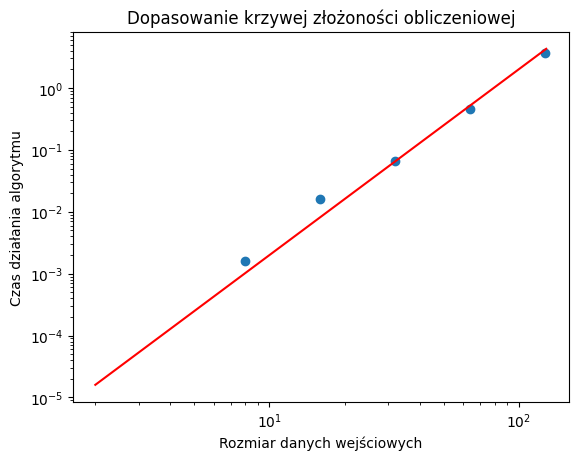

In [147]:
plt.scatter(sizes, binet_times)
x = np.linspace(2, 129, 1000)
y = 0.000002 * x ** 3
plt.plot(x, y, color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rozmiar danych wejściowych")
plt.ylabel("Czas działania algorytmu")
plt.title("Dopasowanie krzywej złożoności obliczeniowej")
plt.show()

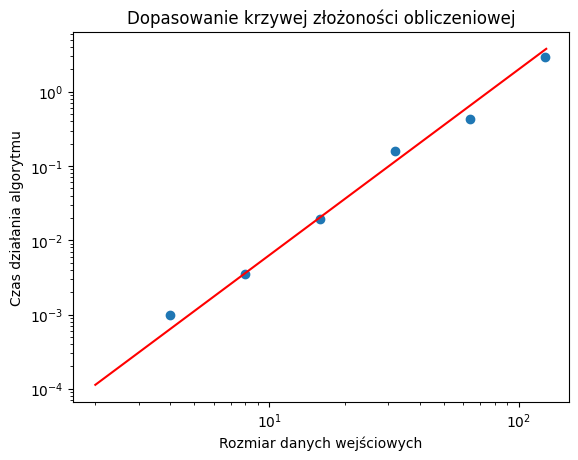

In [158]:
plt.scatter(sizes, strassen_times)
x = np.linspace(2, 129, 1000)
y = 0.00002 * x ** 2.5
plt.plot(x, y, color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rozmiar danych wejściowych")
plt.ylabel("Czas działania algorytmu")
plt.title("Dopasowanie krzywej złożoności obliczeniowej")
plt.show()

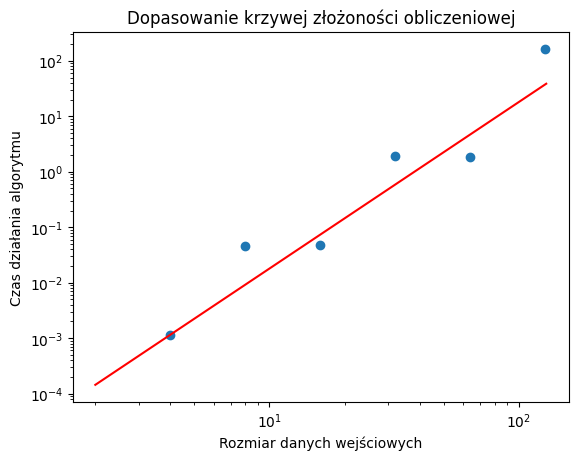

In [167]:
plt.scatter(sizes, ai_times)
x = np.linspace(2, 129, 1000)
y = 0.000018 * x ** 3
plt.plot(x, y, color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rozmiar danych wejściowych")
plt.ylabel("Czas działania algorytmu")
plt.title("Dopasowanie krzywej złożoności obliczeniowej")
plt.show()

In [290]:
n = 4
A = generate_random_matrix(n)
B = generate_random_matrix(n)
A = np.round(A, 2)
B = np.round(B, 2)

print("A =\n" + str(A))
print("B =\n" + str(B))

A =
[[0.88 0.65 0.41 0.29]
 [0.8  0.66 0.23 0.75]
 [0.76 0.45 0.03 0.47]
 [0.99 0.1  0.88 0.35]]
B =
[[0.84 0.78 0.24 0.42]
 [0.94 0.08 0.71 0.03]
 [0.74 0.1  0.36 0.06]
 [0.68 0.83 0.97 0.03]]


In [292]:
if not is_the_right_size(A):
    A = pad_to_power_of_two(A)
if not is_the_right_size(B):
    B = pad_to_power_of_two(B)

C1 = matrix_mult_recursive(A, B)
C1 = restore_original(C1, n)
print("Binet algorithm:")
print(C1)

C2 = strassen_recursive(A, B)
C2 = restore_original(C2, n)
print("Strassen algorithm:")
print(C2)

A = restore_original(A, n)
B = restore_original(B, n)
A = pad_to_4n_5n(A)
B = pad_to_5n(B)

C3 = ai_recursive(A, B)
C3 = restore_original_4n_5n(C3, n, n)
print("AI algorithm:")
print(C3)

Binet algorithm:
[[1.8508 1.0201 1.1016 0.4224]
 [1.9726 1.3223 1.4709 0.3921]
 [1.4032 1.0219 0.9686 0.3486]
 [1.8148 1.1587 0.9649 0.4821]]
Strassen algorithm:
[[1.8508 1.0201 1.1016 0.4224]
 [1.9726 1.3223 1.4709 0.3921]
 [1.4032 1.0219 0.9686 0.3486]
 [1.8148 1.1587 0.9649 0.4821]]
AI algorithm:
[[1.8508 1.0201 1.1016 0.4224]
 [1.9726 1.3223 1.4709 0.3921]
 [1.4032 1.0219 0.9686 0.3486]
 [1.8148 1.1587 0.9649 0.4821]]
